In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re

In [3]:
# before getting into modeling, we need to do some feature engineering. Looking at 
# the relationship between different features and the labels

# splitting the whole dataset into 7:2:1
# with different parameter combinations, train the classifier on 70% of the data
# get the performance metrics on the 20% of the data
# perform a grid search for the optimal combination of parameters for the classifiers
# once found the best combination of parameters, use them to train model on 90% of the data
# fit on the rest 10% and calculate the test metrics. 

In [4]:
final = pd.read_csv("final.csv", 
                             names = ['case' ,'platform', 'customer_id', 'timeStamp',
                                      'matched_payment_complete', 'label', 'name', 'email', 'gender', 'age',
                                      'home_type', 'square_footage', 'number_of_bedrooms', 'number_of_floors',
                                      'household', 'platform_y', 'street', 'suburb'])
# label == 1 meaning it's fraud
# label == 0 meaning it's not fraud 
final.label = final.label.map({1:1,-1:0})
final.head()

,case,platform,customer_id,timeStamp,matched_payment_complete,label,name,email,gender,age,home_type,square_footage,number_of_bedrooms,number_of_floors,household,platform_y,street,suburb
0,90527688b31d445,mobile_browser,99ccf1,1.483194e+09,1,1,Nicole Berry,Nicole Berry@hotmail.com,male,29,1,311.803620,2,1,"[{'name': 'Oscar Berry', 'age': 25, 'gender': ...",mobile_browser,66 Lake Jamieview,PSC
1,4c9ab2942b484f2,pc_browser,9bae09,1.483197e+09,1,0,Brandi Harris,Brandi Harris@duncan.com,male,62,1,523.432957,2,1,"[{'name': 'Michael Harris', 'age': 12, 'gender...",pc_browser,60 West Lisaside,Jamie Port Suite
2,cf1d5d9af6d54ef,pc_browser,b7aab4,1.483201e+09,1,1,Christopher Moody,Christopher Moody@green.info,male,40,1,221.633267,3,1,[],pc_browser,120 Danielmouth,Unit Box
3,ae3f3d4c667a455,pc_browser,2bc68b,1.483205e+09,1,1,Loretta Steele,Loretta Steele@patton-smith.biz,female,48,1,301.854950,3,1,"[{'name': 'Zachary Steele', 'age': 48, 'gender...",pc_browser,73 Edwardfurt,Michelle Crossing Suite
4,5f4bd7c6884b4d1,mobile_browser,48802d,1.483211e+09,1,1,Taylor Ortiz,Taylor Ortiz@reyes.com,male,28,1,282.311278,2,1,"[{'name': 'Stephen Ortiz', 'age': 25, 'gender'...",mobile_browser,39 Garciahaven,Melissa Roads


In [5]:
by_suburb = final[['suburb','label']].groupby("suburb").agg(['sum','count'])
by_suburb['fraud_ratio'] = by_suburb["label","sum"] / by_suburb["label","count"]
by_suburb = by_suburb.sort_values(by ='fraud_ratio' ,ascending = False)
by_suburb.head(10)

label       fraud_ratio
                        sum count            
suburb                                       
Banks Points             29   164    0.176829
Larry View               28   160    0.175000
Connie Terrace           20   120    0.166667
Hannah Road Apt.         25   162    0.154321
Rebecca Island           27   183    0.147541
Garcia Mall              30   219    0.136986
Bolton Point Apt.        20   149    0.134228
Taylor Park              27   203    0.133005
Woods Trafficway Apt.    28   212    0.132075
Coleman View Apt.        27   215    0.125581

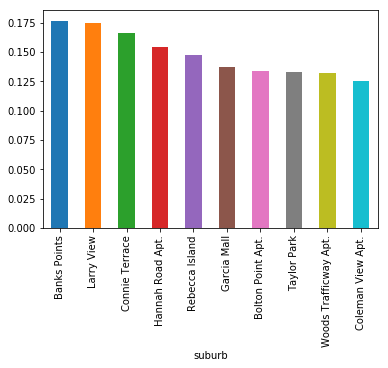

In [6]:
by_suburb.head(10).fraud_ratio.plot.bar()
plt.show()
# top 10 fradulent suburbs

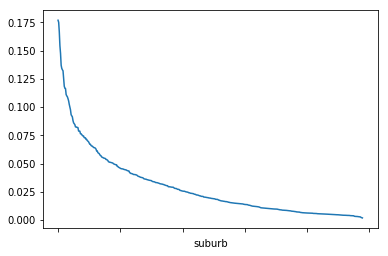

In [7]:
# some suburbs are more likely to produce frauds 
# the fraud ratio varis a lot across differen suburbs, 
# making suburb a good predictor
by_suburb.fraud_ratio.plot()

In [8]:
# then we invistigate different platforms 
by_platform = final[['platform','label']].groupby("platform").agg(['sum','count'])
by_platform['fraud_ratio'] = by_platform["label","sum"] / by_platform["label","count"]
by_platform = by_platform.sort_values(by ='fraud_ratio' ,ascending = False)
by_platform
# as we can see, claims coming from mobile apps are more
# end up being frauds, while phone calls are never fradulent 

label         fraud_ratio
                 sum   count            
platform                                
mobile_app      2096  114929    0.018237
pc_browser      5362  345389    0.015525
mobile_browser  3212  256910    0.012502
phone_call         0  122410    0.000000

In [9]:
# we can look at gender distribution as well
by_gender = final[['gender','label']].groupby("gender").agg(['sum','count'])
by_gender['fraud_ratio'] = by_gender["label","sum"] / by_gender["label","count"]
by_gender = by_gender.sort_values(by ='fraud_ratio' ,ascending = False)
by_gender
# there isn't distinct difference when it comes to gender 
# we can conduct statistical test to validate these results

label         fraud_ratio
         sum   count            
gender                          
female  5370  417554    0.012861
male    5300  422084    0.012557

In [59]:
X = final.drop("label", axis =1 )
Y = final.label

del X['platform_y']
del X['case']
del X['email']
del X['street']
del X['household']
del X['name']
del X['customer_id']

X.gender = X.gender.map({"male":1,"female":0})

# categorial variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(X.suburb.unique().tolist()) # taking all the suburbs 
X.suburb = le.transform(X.suburb)

le_plat = preprocessing.LabelEncoder()
le_plat.fit(X.platform.unique().tolist()) # taking all the suburbs 
X.platform = le_plat.transform(X.platform)

X.head()

,platform,timeStamp,matched_payment_complete,gender,age,home_type,square_footage,number_of_bedrooms,number_of_floors,suburb
0,1,1.483194e+09,1,1,29,1,311.803620,2,1,325
1,2,1.483197e+09,1,1,62,1,523.432957,2,1,189
2,2,1.483201e+09,1,1,40,1,221.633267,3,1,453
3,2,1.483205e+09,1,0,48,1,301.854950,3,1,297
4,1,1.483211e+09,1,1,28,1,282.311278,2,1,288


In [60]:
mid = int(X.shape[0]*0.8)
X_train = X[:mid]
Y_train = Y[:mid]
X_test = X[mid:]
Y_test = Y[mid:]

In [62]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, Y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.997
